In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [3]:
train = pd.read_csv('train.csv/train.csv')

In [4]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [6]:
test = pd.read_csv('test.csv/test.csv')
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
songs = pd.read_csv('songs.csv/songs.csv')
members = pd.read_csv('members.csv/members.csv')
songs_extra = pd.read_csv('song_extra_info.csv/song_extra_info.csv')

In [8]:
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


Добавим вместо колонки isrc год выпуска песни. ISRC строится также как показано на картинке ниже. Поэтому берем 5-7 символы (датасет 2017 года, поэтому если больше 17, то значит прошлый век)

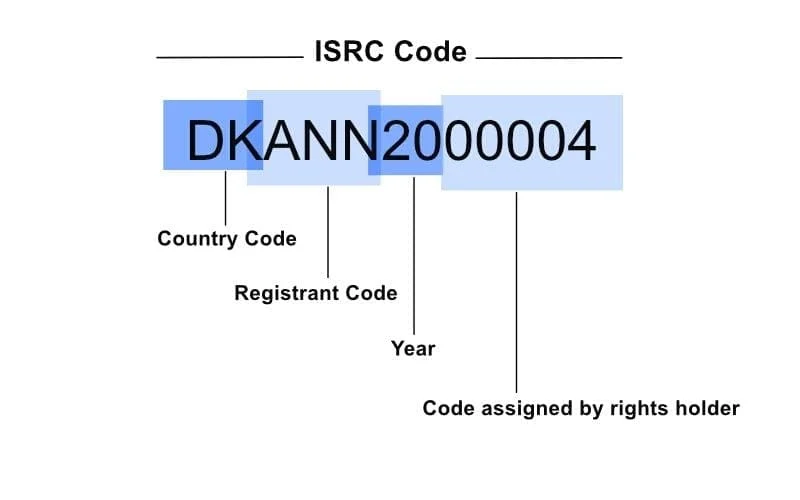

In [9]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [10]:
songs_extra.head()

,song_id,song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0


In [11]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [12]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


Чтобы не отходить от кассы сразу переведу registration_init_time и expiration_date в адекватный вид

In [13]:
members.registration_init_time = pd.to_datetime(members.registration_init_time, format='%Y%m%d')
members['registration_init_time_year'] = members['registration_init_time'].dt.year
members['registration_init_time_month'] = members['registration_init_time'].dt.month
members['registration_init_time_day'] = members['registration_init_time'].dt.day

members.expiration_date = pd.to_datetime(members.expiration_date,  format='%Y%m%d')
members['expiration_date_year'] = members['expiration_date'].dt.year
members['expiration_date_month'] = members['expiration_date'].dt.month
members['expiration_date_day'] = members['expiration_date'].dt.day

In [14]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13,2017,1,26,2017,6,13


In [15]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
count,34403.000000,34403.000000,34403.000000,34403,34403,34403.000000,34403.000000,34403.000000,34403.000000,34403.000000,34403.000000
mean,5.371276,12.280935,5.953376,2014-06-07 19:28:51.093218560,2017-06-03 10:39:36.839229184,2013.926751,6.593408,15.861437,2016.821876,7.729326,15.349301
min,1.000000,-43.000000,3.000000,2004-03-26 00:00:00,1970-01-01 00:00:00,2004.000000,1.000000,1.000000,1970.000000,1.000000,1.000000
25%,1.000000,0.000000,4.000000,2012-10-27 00:00:00,2017-02-01 00:00:00,2012.000000,2.000000,8.000000,2017.000000,6.000000,8.000000
50%,1.000000,0.000000,7.000000,2015-09-05 00:00:00,2017-09-09 00:00:00,2015.000000,7.000000,16.000000,2017.000000,9.000000,15.000000
75%,10.000000,25.000000,9.000000,2016-11-02 00:00:00,2017-09-30 00:00:00,2016.000000,10.000000,23.000000,2017.000000,10.000000,22.000000
max,22.000000,1051.000000,16.000000,2017-02-28 00:00:00,2020-10-17 00:00:00,2017.000000,12.000000,31.000000,2020.000000,12.000000,31.000000
std,6.243929,18.170251,2.287534,NaN,NaN,2.958737,3.996440,8.781187,0.738937,3.249545,8.829568


In [16]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [17]:
train = pd.merge(train, songs, on='song_id', how = 'left')
train = pd.merge(train, members, on = 'msno', how = 'left')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 24 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   msno                          object        
 1   song_id                       object        
 2   source_system_tab             object        
 3   source_screen_name            object        
 4   source_type                   object        
 5   target                        int64         
 6   song_length                   float64       
 7   genre_ids                     object        
 8   artist_name                   object        
 9   composer                      object        
 10  lyricist                      object        
 11  language                      float64       
 12  city                          int64         
 13  bd                            int64         
 14  gender                        object        
 15  registered_via                in

In [18]:
train.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
count,7.377418e+06,7.377304e+06,7.377268e+06,7.377418e+06,7.377418e+06,7.377418e+06,7377418,7377418,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06
mean,5.035171e-01,2.451210e+05,1.860933e+01,7.511399e+00,1.753927e+01,6.794068e+00,2013-04-07 12:51:02.757403904,2017-09-21 11:55:19.909811200,2.012741e+03,6.832306e+00,1.581532e+01,2.017072e+03,8.341742e+00,1.562338e+01
min,0.000000e+00,1.393000e+03,-1.000000e+00,1.000000e+00,-4.300000e+01,3.000000e+00,2004-03-26 00:00:00,1970-01-01 00:00:00,2.004000e+03,1.000000e+00,1.000000e+00,1.970000e+03,1.000000e+00,1.000000e+00
25%,0.000000e+00,2.147260e+05,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2011-07-05 00:00:00,2017-09-11 00:00:00,2.011000e+03,3.000000e+00,8.000000e+00,2.017000e+03,9.000000e+00,8.000000e+00
50%,1.000000e+00,2.418120e+05,3.000000e+00,5.000000e+00,2.100000e+01,7.000000e+00,2013-10-23 00:00:00,2017-09-26 00:00:00,2.013000e+03,7.000000e+00,1.600000e+01,2.017000e+03,9.000000e+00,1.500000e+01
75%,1.000000e+00,2.721600e+05,5.200000e+01,1.300000e+01,2.900000e+01,9.000000e+00,2015-10-22 00:00:00,2017-10-06 00:00:00,2.015000e+03,1.000000e+01,2.300000e+01,2.017000e+03,1.000000e+01,2.300000e+01
max,1.000000e+00,1.085171e+07,5.900000e+01,2.200000e+01,1.051000e+03,1.300000e+01,2017-01-31 00:00:00,2020-10-17 00:00:00,2.017000e+03,1.200000e+01,3.100000e+01,2.020000e+03,1.200000e+01,3.100000e+01
std,4.999877e-01,6.734471e+04,2.117681e+01,6.641625e+00,2.155447e+01,2.275774e+00,NaN,NaN,3.018861e+00,3.700723e+00,8.768549e+00,3.982536e-01,2.511360e+00,9.107235e+00


Смерждили, посмотрели снова describe. Меня напрягали значения для members, в колонке bd, но в данный было указано, что они будут быть больше. Возможно их стоило отбросить как выбросы, однако я этого не делал

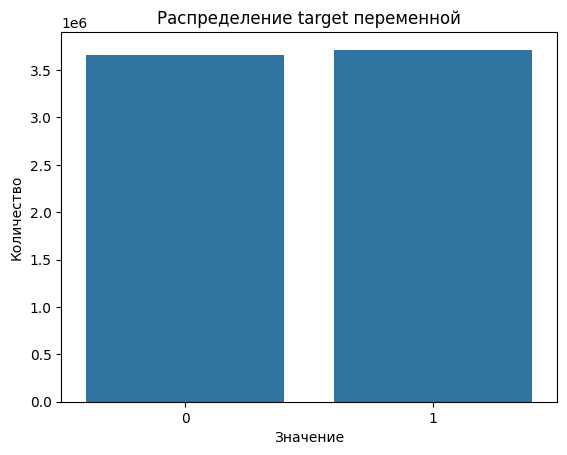

In [19]:
sns.countplot(x='target', data=train)
plt.title('Распределение target переменной')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Хоть данные и с Кэгла, но все же убедиться стоило, что нет одного класса - 90 %, второго 10-%. И на всякий - у нас бинарная классификация

In [20]:
label_encoder = LabelEncoder()
for i in train.columns:
    if train[i].dtype == 'object':
        train[i] = label_encoder.fit_transform(train[i])

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 24 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   msno                          int32         
 1   song_id                       int32         
 2   source_system_tab             int32         
 3   source_screen_name            int32         
 4   source_type                   int32         
 5   target                        int64         
 6   song_length                   float64       
 7   genre_ids                     int32         
 8   artist_name                   int32         
 9   composer                      int32         
 10  lyricist                      int32         
 11  language                      float64       
 12  city                          int64         
 13  bd                            int64         
 14  gender                        int32         
 15  registered_via                in

In [22]:
missing_values = train.isna().sum()
print(missing_values)

msno                              0
song_id                           0
source_system_tab                 0
source_screen_name                0
source_type                       0
target                            0
song_length                     114
genre_ids                         0
artist_name                       0
composer                          0
lyricist                          0
language                        150
city                              0
bd                                0
gender                            0
registered_via                    0
registration_init_time            0
expiration_date                   0
registration_init_time_year       0
registration_init_time_month      0
registration_init_time_day        0
expiration_date_year              0
expiration_date_month             0
expiration_date_day               0
dtype: int64


In [23]:
train = train.fillna(value = train.mean())

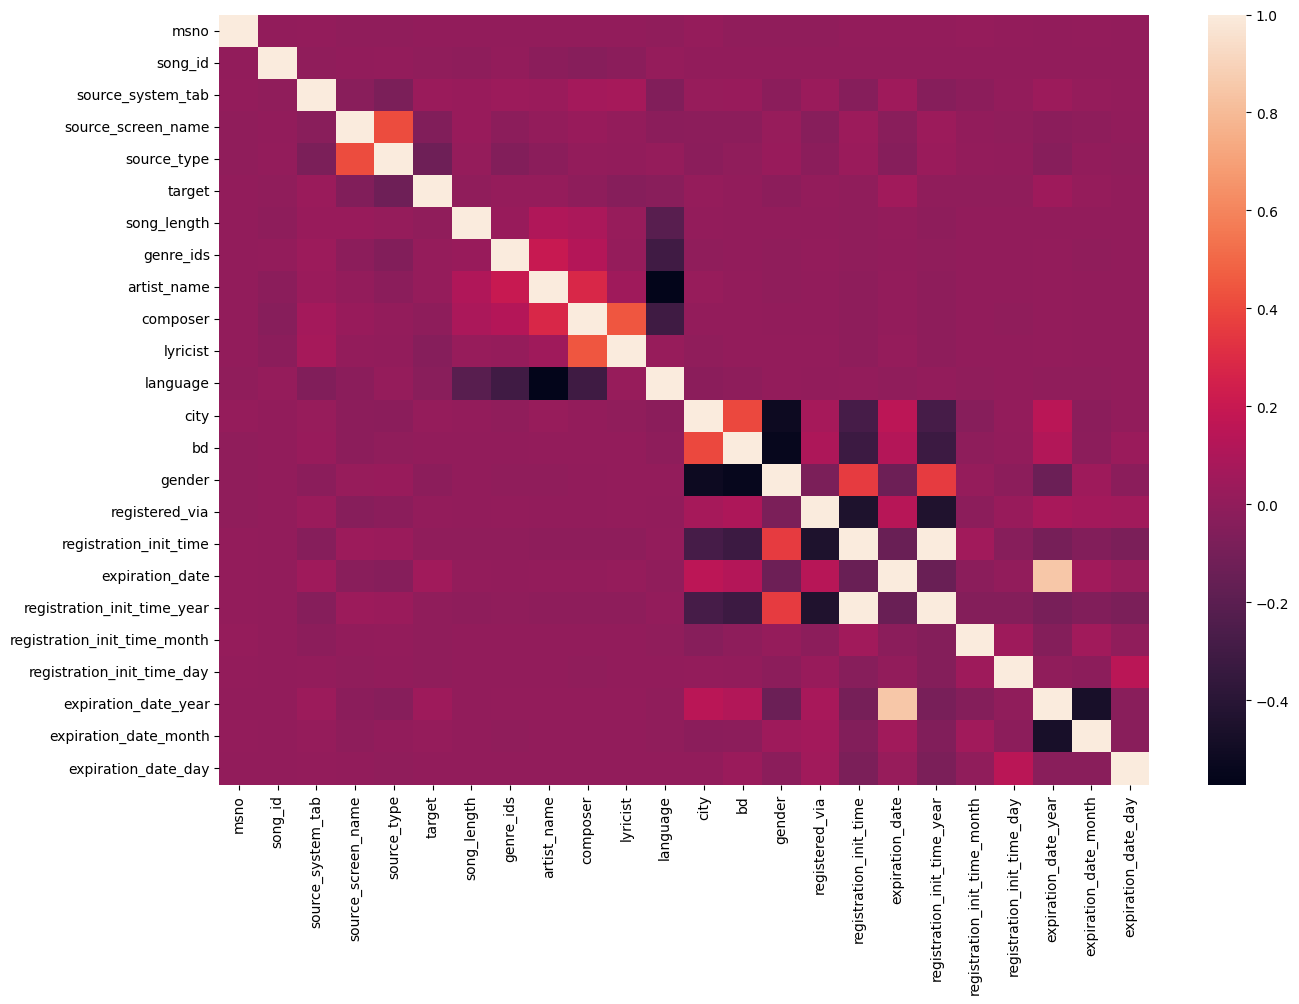

In [24]:
plt.figure(figsize=[15,10])
sns.heatmap(train.corr())
plt.show()

In [26]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,6,1,206471.0,285,3277,14581,...,2,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,17259,223479,3,8,4,1,284584.0,90,31960,76064,...,0,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,17259,120758,3,8,4,1,225396.0,90,21372,45057,...,0,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,17259,23707,3,8,4,1,255512.0,6,27439,36700,...,0,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,8158,33308,1,7,6,1,187802.0,2,4472,8485,...,2,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


Уберем даты, так как они содержатся в других колонках

In [27]:
train_y = train['target']
train_x = train.drop(columns = ['target', 'expiration_date', 'registration_init_time'], axis = 1)
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.25, random_state = 42, shuffle = False)


Шафл стоит false, потому что судя по Kaggle данные расположены в хронологическом порядке. И с shuffle = False метрика ndcg вырастает на 0.01

Теперь напишем функцию обучения и просто будем смотреть модели. В качестве моделей возьмем 3 варианта - catboost, xgbclassifier, lightgbm

In [28]:
def train_test (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    result_score = ndcg_score(y_test.values.reshape(1, -1), predictions.reshape(1, -1))
    print("NDCG_SCORE = ", result_score)
    return result_score

Проведем первые тесты

In [30]:
model = CatBoostClassifier(iterations=1000, learning_rate=1e-4,  depth=6, loss_function='CrossEntropy')
train_test(model, X_train, y_train, X_val, y_val)

0:	learn: 0.6924493	total: 530ms	remaining: 8m 49s
1:	learn: 0.6924405	total: 893ms	remaining: 7m 25s
2:	learn: 0.6924400	total: 1.23s	remaining: 6m 48s
3:	learn: 0.6924539	total: 1.57s	remaining: 6m 29s
4:	learn: 0.6924695	total: 1.89s	remaining: 6m 17s
5:	learn: 0.6926227	total: 2.22s	remaining: 6m 7s
6:	learn: 0.6927200	total: 2.54s	remaining: 6m 1s
7:	learn: 0.6927346	total: 2.86s	remaining: 5m 55s
8:	learn: 0.6927427	total: 3.19s	remaining: 5m 51s
9:	learn: 0.6927754	total: 3.52s	remaining: 5m 48s
10:	learn: 0.6928248	total: 3.9s	remaining: 5m 50s
11:	learn: 0.6928268	total: 4.23s	remaining: 5m 48s
12:	learn: 0.6928175	total: 4.58s	remaining: 5m 47s
13:	learn: 0.6927959	total: 4.92s	remaining: 5m 46s
14:	learn: 0.6928053	total: 5.23s	remaining: 5m 43s
15:	learn: 0.6928172	total: 5.55s	remaining: 5m 41s
16:	learn: 0.6928210	total: 5.87s	remaining: 5m 39s
17:	learn: 0.6928269	total: 6.19s	remaining: 5m 37s
18:	learn: 0.6927281	total: 6.52s	remaining: 5m 36s
19:	learn: 0.6927261	tota

0.9448426884763098

In [43]:
model = LGBMClassifier(learning_rate=0.1, n_estimators=100, num_leaves=30)
train_test(model, X_train, y_train, X_val, y_val)

[LightGBM] [Info] Number of positive: 2963461, number of negative: 2569602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 5533063, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535591 -> initscore=0.142607
[LightGBM] [Info] Start training from score 0.142607
NDCG_SCORE =  0.9510738956353855


0.9510738956353855

In [31]:
model = XGBClassifier(objective = 'binary:logistic', learning_rate = 1e-4, max_depth = 5, n_estimators = 100, gamma = 0, min_child_weight = 3)
train_test(model, X_train, y_train, X_val, y_val)

NDCG_SCORE =  0.9453989748624863


0.9453989748624863

Немножко GridSearchа, для перебора гиперпараметров и небольшой кросс-валидации

In [32]:
def ndcg_scorer(y_true, y_score):
    return ndcg_score([y_true], [y_score])

model = CatBoostClassifier()
param_grid = {
    'iterations': [100, 1000],
    'learning_rate': [1e-4, 0.1],
    'depth': [5, 7],
    'loss_function': ['CrossEntropy']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(ndcg_scorer))
grid_search.fit(X_train, y_train)
print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший результат:", grid_search.best_score_)

0:	learn: 0.6929721	total: 201ms	remaining: 19.9s
1:	learn: 0.6929604	total: 404ms	remaining: 19.8s
2:	learn: 0.6929588	total: 610ms	remaining: 19.7s
3:	learn: 0.6929645	total: 850ms	remaining: 20.4s
4:	learn: 0.6929632	total: 1.06s	remaining: 20.1s
5:	learn: 0.6930172	total: 1.28s	remaining: 20.1s
6:	learn: 0.6930141	total: 1.49s	remaining: 19.8s
7:	learn: 0.6930267	total: 1.71s	remaining: 19.7s
8:	learn: 0.6930297	total: 1.92s	remaining: 19.5s
9:	learn: 0.6930088	total: 2.14s	remaining: 19.2s
10:	learn: 0.6930129	total: 2.37s	remaining: 19.2s
11:	learn: 0.6930171	total: 2.58s	remaining: 19s
12:	learn: 0.6930492	total: 2.79s	remaining: 18.7s
13:	learn: 0.6930427	total: 2.99s	remaining: 18.3s
14:	learn: 0.6930252	total: 3.19s	remaining: 18.1s
15:	learn: 0.6930261	total: 3.38s	remaining: 17.8s
16:	learn: 0.6930202	total: 3.58s	remaining: 17.5s
17:	learn: 0.6930104	total: 3.78s	remaining: 17.2s
18:	learn: 0.6930214	total: 3.98s	remaining: 17s
19:	learn: 0.6930055	total: 4.17s	remaining: 

In [54]:
def ndcg_scorer(y_true, y_score):
    return ndcg_score([y_true], [y_score])

model = lgb.LGBMClassifier()
param_grid = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(ndcg_scorer))
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший результат:", grid_search.best_score_)

Лучшие гиперпараметры: {learning_rate: 0.1, n_estimators: 1000, num_leaves: 100}
Лучший результат: 0.9666722185249493


In [57]:
def ndcg_scorer(y_true, y_score):
    return ndcg_score([y_true], [y_score])

model = XGBClassifier()
param_grid = {
    'n_estimators': [100],
    'learning_rate': [1e-4, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(ndcg_scorer))
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший результат:", grid_search.best_score_)

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Лучший результат: 0.9658836100116347


Теперь по итогу возьмем 3 лучших модели, по одной для каждого классификатора, посмотрим итоговю метрику ndcg на них

In [59]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=7, loss_function='CrossEntropy')
train_test(model, X_train, y_train, X_val, y_val)

0:	learn: 0.6835567	total: 386ms	remaining: 6m 25s
1:	learn: 0.6756778	total: 775ms	remaining: 6m 26s
2:	learn: 0.6695752	total: 1.18s	remaining: 6m 30s
3:	learn: 0.6647193	total: 1.54s	remaining: 6m 23s
4:	learn: 0.6604907	total: 1.92s	remaining: 6m 21s
5:	learn: 0.6573311	total: 2.32s	remaining: 6m 24s
6:	learn: 0.6545678	total: 2.73s	remaining: 6m 27s
7:	learn: 0.6522447	total: 3.1s	remaining: 6m 23s
8:	learn: 0.6504894	total: 3.47s	remaining: 6m 22s
9:	learn: 0.6489221	total: 3.84s	remaining: 6m 20s
10:	learn: 0.6475743	total: 4.25s	remaining: 6m 22s
11:	learn: 0.6464847	total: 4.62s	remaining: 6m 20s
12:	learn: 0.6455569	total: 5.02s	remaining: 6m 21s
13:	learn: 0.6447200	total: 5.41s	remaining: 6m 21s
14:	learn: 0.6440620	total: 5.81s	remaining: 6m 21s
15:	learn: 0.6434543	total: 6.22s	remaining: 6m 22s
16:	learn: 0.6429814	total: 6.58s	remaining: 6m 20s
17:	learn: 0.6423820	total: 7s	remaining: 6m 22s
18:	learn: 0.6420437	total: 7.38s	remaining: 6m 20s
19:	learn: 0.6416960	total

0.9537336529844125

In [60]:
model = LGBMClassifier(learning_rate=0.1, n_estimators=1000, num_leaves=100)
train_test(model, X_train, y_train, X_val, y_val)

[LightGBM] [Info] Number of positive: 2963461, number of negative: 2569602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 5533063, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535591 -> initscore=0.142607
[LightGBM] [Info] Start training from score 0.142607
NDCG_SCORE =  0.95765146463077


0.95765146463077

In [63]:
model = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.1, max_depth = 7, n_estimators = 100)
train_test(model, X_train, y_train, X_val, y_val)

NDCG_SCORE =  0.9517096447467338


0.9517096447467338

Подводя итог. Возможно стоило взять другие классификаторы, однако лучшую точность получил LGBMClassifier. Также предполагаю, что можно было докрутить лучше параметры. Однако лучший ndcg получился - 0.9576. 
